In [1]:
!pip install biopython -q

In [1]:
import operator
from langchain_core.messages import BaseMessage

from typing import TypedDict, Annotated, List
from langchain_core.agents import AgentAction, AgentFinish
from semantic_router.encoders import HuggingFaceEncoder, OpenAIEncoder
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate

/home/godwin/anaconda3/lib/python3.11/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


In [2]:
import os
from Bio import Entrez
from serpapi import GoogleSearch
from dotenv import load_dotenv
from langchain_core.tools import tool


import requests
from bs4 import BeautifulSoup

load_dotenv()

serpapi_params = {
    "engine": "google",
    "api_key": os.getenv("SERPAPI_KEY")
}


# Define your email (required by PubMed)
Entrez.email = "hundredgodwin@gmail.com"

def drug_info(links):

    results = []
    for link in links:

        response = requests.get(link)

        if response.status_code == 200:
            
            soup = BeautifulSoup(response.text, "html.parser")
            summary_container = soup.find('div', class_="monograph_cont")
            uses_container = soup.find_all('div', class_ = "pgContent")
            summary, uses = summary_container.text, uses_container[1].text
            result = f"{summary}\n\n{uses}"
            results.append(result)

    final_response = "\n".join([i for i in results])

    return final_response

def extract_pubmed_abstract(links):

    results = []
    for link in links:

        response = requests.get(link)

        if response.status_code == 200:
            
            soup = BeautifulSoup(response.text, "html.parser")
            abstact_container = soup.find('div', class_="abstract")
            abstract = abstact_container.text
            results.append(abstract)

    final_response = "\n".join([i for i in results])
    return final_response

@tool
def pubmed_search(query: str):
    """Search for articles on PubMed."""
    handle = Entrez.esearch(db="pubmed", term=query, retmax=3)
    record = Entrez.read(handle)
    handle.close()

    if record["IdList"]:
        ids = record["IdList"]
        article_links = [f'https://pubmed.ncbi.nlm.nih.gov/{id}/' for id in ids]
    
        article = extract_pubmed_abstract(article_links)
    
    
    #     # Fetch summary for each ID
        
    #     handle = Entrez.esummary(db="pubmed", id=ids)
    #     summary = Entrez.read(handle)
    #     handle.close()
    #top_results = "\n".join([f'{item["Title"]}: https://pubmed.ncbi.nlm.nih.gov/{item["Id"]}/' for item in summary])
        return f"Top PubMed search results for '{query}':\n{article}"
    else:
        return "No articles found."
  
@tool
def web_search(query: str):
    """Finds research specific knowledge information using Google search. """

    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 5
    })
    results = search.get_dict()["organic_results"]
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts


    
@tool
def drug_search(query: str):
    """Search for medical information on WebMD."""
    search_url = f"https://www.rxlist.com/search/rxl/{query}"
    response = requests.get(search_url)
    
    if response.status_code == 200:# Print the first 5 links
        
        soup = BeautifulSoup(response.text, "html.parser")
        results_container = soup.find('div', class_="searchresults main")
        items = results_container.find_all('li', limit=3)

        if items:
            results = [item.find('a') for item in items]
            links = [link['href'] for link in results]
            top_results = "\n".join([result.text + ": " + result['href'] for result in results])
            drugs_info = drug_info(links)


            return f"Top rxlist search results for '{query}':\n{drugs_info}"
        else:
            return "No relevant WebMD results found."
    else:
        return "Failed to retrieve WebMD results."


def webmd_search(query: str):
    """Search for medical information on WebMD."""
    search_url = f"https://www.webmd.com/search/search_results/default.aspx?query={query}"
    response = requests.get(search_url)
    print(response)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        results = soup.find_all("a", class_="result-title", limit=3)
        if results:
            top_results = "\n".join([result.text + ": " + result['href'] for result in results])
            return f"Top WebMD search results for '{query}':\n{top_results}"
        else:
            return "No relevant WebMD results found."
    else:
        return "Failed to retrieve WebMD results."


In [3]:
import serpapi

In [6]:
serpapi.version

AttributeError: module 'serpapi' has no attribute 'version'

In [2]:
x = []
if x:
    print(2)

In [48]:
def healthline_search(query: str):
    """Search Healthline for medical information."""
    search_url = f"https://www.healthline.com/search?q1={query}"
    response = requests.get(search_url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        results = soup.find("div", class_="css-1hm2gwy")
        print(results)
        if results:
            top_results = "\n".join([result.text.strip() + ": " + result['href'] for result in results])
            return f"Top Healthline search results for '{query}':\n{top_results}"
        else:
            return "No relevant Healthline results found."
    else:
        return "Failed to retrieve Healthline results."

In [49]:
# search_url = f"https://www.healthline.com/search?q1=Menstration"
# response = requests.get(search_url)

# if response.status_code == 200:
#     soup = BeautifulSoup(response.text, "html.parser")
#     results = soup.find("div", class_="css-15x6pli")
#     results = soup.find_all('a', class_ = 'css-1hm2gwy')
#     print(results)

In [73]:
from bs4 import BeautifulSoup
import requests
from Bio import Entrez
from serpapi import GoogleSearch

# PubMed Search Tool
@tool('pubmed_search')
def pubmed_search(query: str):
    """
    Searches PubMed for scientific articles related to a given medical query.
    Returns the top articles and links to their abstracts.
    PubMed is a trusted source for peer-reviewed medical research articles.
    """
    handle = Entrez.esearch(db="pubmed", term=query, retmax=3)
    record = Entrez.read(handle)
    handle.close()

    if record["IdList"]:
        ids = record["IdList"]
        article_links = [f'https://pubmed.ncbi.nlm.nih.gov/{id}/' for id in ids]

        # Extract article abstracts (you'll need an actual method for this)
        article = extract_pubmed_abstract(article_links)

        return f"Top PubMed search results for '{query}':\n{article}"
    else:
        return "No articles found."

# Web Search Tool using Google Search
@tool('web_search')
def web_search(query: str):
    """
    Conducts a Google search using a specific medical query to find relevant
    health information or research articles. Returns the top 5 search results 
    with titles, snippets, and links.
    """
    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 5
    })
    results = search.get_dict()["organic_results"]

    # Formatting results into readable output
    contexts = "\n---\n".join(
        ["\n".join([x["title"], x["snippet"], x["link"]]) for x in results]
    )
    return contexts

# Drug Search Tool on RxList
@tool('drug_search')
def drug_search(query: str):
    """
    Searches RxList for detailed drug information, including uses, side effects, 
    and warnings. RxList is a trusted source for information on prescription 
    and over-the-counter drugs.
    """
    search_url = f"https://www.rxlist.com/search/rxl/{query}"
    response = requests.get(search_url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        results_container = soup.find('div', class_="searchresults main")
        
        if results_container:
            items = results_container.find_all('li', limit=3)
            results = [item.find('a') for item in items]
            links = [link['href'] for link in results]

            # Fetch drug information (requires implementation of drug_info method)
            drugs_info = drug_info(links)

            return f"Top RxList search results for '{query}':\n{drugs_info}"
        else:
            return "No relevant RxList results found."
    else:
        return "Failed to retrieve RxList results."
    
# @tool("query_rewrite")
# def query_rewrite(user_query: str):
#     """
#     Rewrites the user's medical query by correcting any typographical errors and improving clarity 
#     to ensure the query is easily understood and more precise.
    
#     - `user_query`: The original query from the user, which may contain typos or unclear phrasing.
#     """
#     # Use language processing techniques or external services to correct and improve the query.
#     corrected_query = correct_typo_and_improve_clarity(user_query)
    
#     return corrected_query


@tool("medical_response")
def medical_response(response: str, research_steps):
    """
    Provides a detailed and reliable answer to the user's medical query.
    
    - `response`: A well-crafted, concise, and medically accurate response to the user's question.
    """

    if type(research_steps) is list:
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    # if type(sources) is list:
    #     sources = "\n".join([f"- {s}" for s in sources])
    return ""


In [74]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision maker.
Given the user's query you must decide what to do with it based on the
list of tools provided to you.

If you see that a tool has been used (in the scratchpad) with a particular
query, do NOT use that same tool with the same query again. Also, do NOT use
any tool more than twice (ie, if the tool appears in the scratchpad twice, do
not use it again).

You should aim to collect information from a diverse range of sources before
providing the answer to the user. Once you have collected plenty of information
to answer the user's question (stored in the scratchpad) use the medical_response
tool."""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    ("assistant", "scratchpad: {scratchpad}"),
])

In [75]:
tools=[
  pubmed_search,
  web_search,
  drug_search,
  medical_response,
]


class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

# define a function to transform intermediate_steps from list
# of AgentAction to scratchpad string
def create_scratchpad(intermediate_steps: list[AgentAction]):
    research_steps = []
    for i, action in enumerate(intermediate_steps):
        if action.log != "TBD":
            # this was the ToolExecution
           
            research_steps.append(
                f"Tool: {action.tool}, input: {action.tool_input}\n"
                f"Output: {action.log}"
            )
    return "\n---\n".join(research_steps)

In [76]:
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model = "gpt-4o")

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x["chat_history"],
        "scratchpad": lambda x: create_scratchpad(
            intermediate_steps=x["intermediate_steps"]
        ),
    }
    | prompt | llm.bind_tools(tools=tools, tool_choice='auto')
)

In [77]:
inputs = {
    "input": """What is malaria""",
    "chat_history": [],
    "intermediate_steps": [],
}
out = oracle.invoke(inputs)

In [78]:
def run_oracle(state: list):
    # print("run_oracle")
    # print(f"intermediate_steps: {state['intermediate_steps']}")
    print(state)
    out = oracle.invoke(state)
    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0]["args"]
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )
    return {
        "intermediate_steps": [action_out]
    }

def router(state: list):
    # return the tool name to use
    if isinstance(state["intermediate_steps"], list):
        return state["intermediate_steps"][-1].tool
    else:
        # if we output bad format go to final answer
        print("Router invalid format")
        return "medical_response"

In [79]:
tool_str_to_func = {
   "pubmed_search": pubmed_search,
    "web_search": web_search,
    "drug_search": drug_search,
   "medical_response": medical_response
}

def run_tool(state: list):
    # use this as helper function so we repeat less code
    tool_name = state["intermediate_steps"][-1].tool
    tool_args = state["intermediate_steps"][-1].tool_input
    print(f"{tool_name}.invoke(input={tool_args})")
    # run tool
    out = tool_str_to_func[tool_name].invoke(input=tool_args)
    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )
    return {"intermediate_steps": [action_out]}

In [80]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)
graph.add_node("pubmed_search", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("drug_search", run_tool)
graph.add_node("medical_response", run_tool)

graph.set_entry_point("oracle")

graph.add_conditional_edges(
    source="oracle",  # where in graph to start
    path=router,  # function to determine which node is called
)

# create edges from each tool back to the oracle
for tool_obj in tools:
    if tool_obj.name != "medical_response":
        graph.add_edge(tool_obj.name, "oracle")

# if anything goes to final answer, it must then move to END
graph.add_edge("medical_response", END)

runnable = graph.compile()

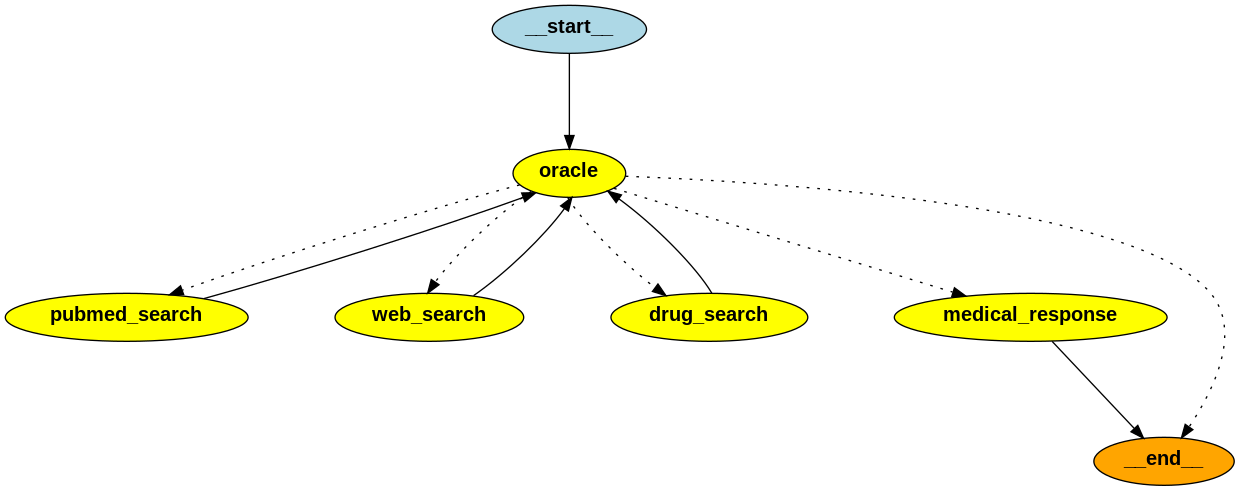

In [81]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [82]:
out = runnable.invoke({
    "input": "tell me something interesting about typhoid patients",
    "chat_history": [],
})

{'input': 'tell me something interesting about typhoid patients', 'chat_history': [], 'intermediate_steps': []}
pubmed_search.invoke(input={'query': 'interesting facts about typhoid patients'})
{'input': 'tell me something interesting about typhoid patients', 'chat_history': [], 'intermediate_steps': [AgentAction(tool='pubmed_search', tool_input={'query': 'interesting facts about typhoid patients'}, log='TBD'), AgentAction(tool='pubmed_search', tool_input={'query': 'interesting facts about typhoid patients'}, log='No articles found.')]}
web_search.invoke(input={'query': 'interesting facts about typhoid patients'})
{'input': 'tell me something interesting about typhoid patients', 'chat_history': [], 'intermediate_steps': [AgentAction(tool='pubmed_search', tool_input={'query': 'interesting facts about typhoid patients'}, log='TBD'), AgentAction(tool='pubmed_search', tool_input={'query': 'interesting facts about typhoid patients'}, log='No articles found.'), AgentAction(tool='web_search',

In [84]:
xr = out["intermediate_steps"][-1].tool_input

In [87]:
print(xr['response'])

Typhoid fever, caused by the bacterium Salmonella Typhi, is an interesting condition with several notable aspects. Approximately 9 million people are infected annually, resulting in about 110,000 deaths. Some patients, known as carriers, may not show symptoms but can still spread the bacteria through their feces and urine. Typhoid fever is also known for causing characteristic skin rashes, and it is not contagious through casual contact but spreads through contaminated food and water. Additionally, around 5% of individuals who recover from typhoid fever can continue to carry and spread the bacteria for a year or longer.


In [92]:
link = 'https://www.rxlist.com/kaletra-capsules-drug.htm'
response = requests.get(link)

if response.status_code == 200:
    
    soup = BeautifulSoup(response.text, "html.parser")
    summary_container = soup.find('div', class_="monograph_cont")
    uses_container = soup.find_all('div', class_ = "pgContent")
    summary, uses = summary_container.text, uses_container[1].text

In [96]:
print(uses)


Uses for Kaletra Capsules
KALETRA is indicated in combination with other
antiretroviral agents for the treatment of HIV1 infection in adults and
pediatric patients (14 days and older).
The following points should be considered when initiating
therapy with KALETRA:

The use of other active agents with KALETRA is associated
    with a greater likelihood of treatment response [see Microbiology and Clinical
      Studies].
Genotypic or phenotypic testing and/or treatment history
    should guide the use of KALETRA [see Microbiology]. The number of
    baseline lopinavir resistance-associated substitutions affects the virologic
    response to KALETRA [see Microbiology].

Dosage for Kaletra Capsules
KALETRA capsules must be taken with food.
Adult Patients

KALETRA capsules 400/100 mg (given as three 133/33 mg
    capsules) twice daily.
KALETRA capsules 800/200 mg (given as six 133/33 mg
    capsules) once daily in patients with less than three lopinavir
    resistance-associated substituti

In [60]:
x = web_search("What is malaria")

In [63]:
print(x)

Malaria - Symptoms & causes
Malaria is a disease caused by a parasite. The parasite is spread to humans through the bites of infected mosquitoes. People who have malaria usually feel ...
https://www.mayoclinic.org/diseases-conditions/malaria/symptoms-causes/syc-20351184
---
Malaria
Malaria is a life-threatening disease spread to humans by some types of mosquitoes. It is mostly found in tropical countries. It is preventable ...
https://www.who.int/news-room/fact-sheets/detail/malaria
---
Malaria: Causes, Symptoms, Diagnosis, Treatment & ...
Malaria is a serious, sometimes fatal, illness caused by parasites deposited into people by infected mosquitos. It can be cured with the right medication.
https://my.clevelandclinic.org/health/diseases/15014-malaria


In [41]:
search_url = f"https://www.rxlist.com/search/rxl/paracetamol"
response = requests.get(search_url)
soup = BeautifulSoup(response.text, "html.parser")
results = soup.find_all("li", class_="searchresults main", limit=3)
print(response)

<Response [200]>


In [39]:
results = soup.find_all('li', class_=['searchresults main'], limit=5)

In [48]:
import requests
from bs4 import BeautifulSoup

# URL of the page to scrape
search_url = "https://www.rxlist.com/search/rxl/paracetamol"
response = requests.get(search_url)

# Parse the page content with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")

# Find the container with the class 'searchresults main'
results_container = soup.find('div', class_="searchresults main")
print(results_container)

<div class="searchresults main">
<h3>Drugs</h3>
<ul>
<li><a href="https://www.rxlist.com/supartz-fx-drug.htm"><span class="brand">Brand: Supartz FX</span><span class="generic">Generic: Sodium Hyaluronate Solution</span></a></li>
</ul>
<div class="gradient"></div>
<div class="more">
<span class="icon-arrow-right2"></span>
</div>
</div>


In [ ]:

# Find all 'li' elements within that container
items = results_container.find_all('li', limit=5)

# Print the first 5 links
for item in items:
    link = item.find('a')
    print(f"Link: {link['href']}, Text: {link.text.strip()}")

In [44]:
import requests
from bs4 import BeautifulSoup

# URL of the page to scrape
search_url = "https://www.rxlist.com/search/rxl/paracetamol"
response = requests.get(search_url)

# Parse the page content with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")

# Find all divs with class 'searchresults main'
containers = soup.find_all('div', class_="searchresults main")

# Iterate through each container to extract 'li' items
for index, container in enumerate(containers, start=1):
    print(f"Container {index}:")
    items = container.find_all('li', limit=5)
    for item in items:
        link = item.find('a')
        print(f"Link: {link['href']}, Text: {link.text.strip()}")


Container 1:
Link: https://www.rxlist.com/supartz-fx-drug.htm, Text: Brand: Supartz FXGeneric: Sodium Hyaluronate Solution


In [ ]:
<div class="searchresults main">
                        <h3>Drugs</h3>
                        <ul style="height: 750px;">
                            <li><a href="https://www.rxlist.com/diclofenac/generic-drug.htm"><span class="brand">Generic: Diclofenac</span></a></li><li><a href="https://www.rxlist.com/arthrotec-drug.htm"><span class="brand">Brand: Arthrotec</span><span class="generic">Generic: Diclofenac Sodium, Misoprostol</span></a></li><li><a href="https://www.rxlist.com/cambia-drug.htm"><span class="brand">Brand: Cambia</span><span class="generic">Generic: Diclofenac Potassium for Oral Solution</span></a></li><li><a href="https://www.rxlist.com/cataflam-drug.htm"><span class="brand">Brand: Cataflam</span><span class="generic">Generic: Diclofenac Potassium Immediate-Release Tablets</span></a></li><li><a href="https://www.rxlist.com/diclostream-drug.htm"><span class="brand">Brand: Diclostream</span><span class="generic">Generic: Diclofenac Sodium 1.5% Solution and Menthol 10% Topical Liquid</span></a></li><li><a href="https://www.rxlist.com/diclozor-drug.htm"><span class="brand">Brand: Diclozor Gel</span><span class="generic">Generic: Diclofenac Sodium Gel</span></a></li><li><a href="https://www.rxlist.com/dyloject-drug.htm"><span class="brand">Brand: Dyloject</span><span class="generic">Generic: Diclofenac Sodium for Injection</span></a></li><li><a href="https://www.rxlist.com/flector-patch-drug.htm"><span class="brand">Brand: Flector Patch</span><span class="generic">Generic: Diclofenac Epolamine Topical Patch</span></a></li><li><a href="https://www.rxlist.com/licart-drug.htm"><span class="brand">Brand: Licart</span><span class="generic">Generic: Diclofenac Epolamine Topical System</span></a></li><li><a href="https://www.rxlist.com/lofena-drug.htm"><span class="brand">Brand: Lofena</span><span class="generic">Generic: Diclofenac Potassium Tablets</span></a></li><li><a href="https://www.rxlist.com/pennsaid-drug.htm"><span class="brand">Brand: PENNSAID</span><span class="generic">Generic: Diclofenac Sodium Topical Solution</span></a></li><li><a href="https://www.rxlist.com/solaraze-drug.htm"><span class="brand">Brand: Solaraze</span><span class="generic">Generic: Diclofenac Sodium</span></a></li><li><a href="https://www.rxlist.com/voltaren-drug.htm"><span class="brand">Brand: Voltaren</span><span class="generic">Generic: Diclofenac Sodium</span></a></li><li><a href="https://www.rxlist.com/voltaren-gel-drug.htm"><span class="brand">Brand: Voltaren Gel</span><span class="generic">Generic: Diclofenac Sodium Gel</span></a></li><li><a href="https://www.rxlist.com/voltaren-ophthalmic-drug.htm"><span class="brand">Brand: Voltaren Ophthalmic</span><span class="generic">Generic: Diclofenac Sodium Ophthalmic Solution</span></a></li><li><a href="https://www.rxlist.com/voltaren-xr-drug.htm"><span class="brand">Brand: Voltaren XR</span><span class="generic">Generic: Diclofenac Sodium Extended-Release Tablets</span></a></li><li><a href="https://www.rxlist.com/zipsor-drug.htm"><span class="brand">Brand: Zipsor</span><span class="generic">Generic: Diclofenac Potassium Liquid Filled Capsules</span></a></li><li><a href="https://www.rxlist.com/zorvolex-drug.htm"><span class="brand">Brand: Zorvolex</span><span class="generic">Generic: Diclofenac Capsules</span></a></li><li><a href="https://www.rxlist.com/celebrex-drug.htm"><span class="brand">Brand: Celebrex</span><span class="generic">Generic: Celecoxib</span></a></li><li><a href="https://www.rxlist.com/concensi-drug.htm"><span class="brand">Brand: Concensi</span><span class="generic">Generic: Amlodipine and Celecoxib Tablet</span></a></li><li><a href="https://www.rxlist.com/xyrem-drug.htm"><span class="brand">Brand: Xyrem</span><span class="generic">Generic: Sodium Oxybate</span></a></li><li><a href="https://www.rxlist.com/sandimmune-drug.htm"><span class="brand">Brand: Sandimmune</span><span class="generic">Generic: Cyclosporine</span></a></li><li><a href="https://www.rxlist.com/gengraf-oral-solution-drug.htm"><span class="brand">Brand: Gengraf Oral Solution</span><span class="generic">Generic: Cyclosporine Oral Solution</span></a></li><li><a href="https://www.rxlist.com/gengraf-capsules-drug.htm"><span class="brand">Brand: Gengraf Capsules</span><span class="generic">Generic: Cyclosporine Capsules</span></a></li><li><a href="https://www.rxlist.com/neoral-drug.htm"><span class="brand">Brand: Neoral</span><span class="generic">Generic: Cyclosporine</span></a></li>
                        </ul>
                        <div class="gradient"></div>
                        <div class="more">
                            <span class="icon-arrow-right2"></span>
                        </div>
                    </div>

In [26]:
search_url = f"https://www.webmd.com/search/search_results/default.aspx?query=malaria"
response = requests.get(search_url)
print(response)

<Response [403]>


In [19]:
print(web_search("What is malaria?"))

KeyError: 'organic_results'

In [14]:
query = "what is malaria?"
search_url = f"https://www.webmd.com/search/search_results/default.aspx?query={query}"
response = requests.get(search_url)
print(response)

<Response [403]>
